In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.adam import ADAM
from models.irls import IRLS
from models.sgd import SGD
from datasets.read import read_all_datasets

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Task 3.4
Compare the classification performance of logistic regression (try all 3 methods: IWLS, SGD and ADAM) and 4 popular classification methods: LDA (Linear Discriminant analysis), QDA (Quadratic Discriminant Analysis), Decision tree and Random Forest. 
Use available implementations, e.g. from scikit-learn library.

In [5]:
# Load saved datasets
import cloudpickle

try:
    with open('datasets.pkl', 'rb') as f:
        datasets = cloudpickle.load(f)
        print("Loaded datasets from file")
except FileNotFoundError:
    datasets = None

if datasets is None:
    datasets = read_all_datasets('datasets/')


Loaded datasets from file


In [31]:
# Save datasets
import cloudpickle

with open('datasets.pkl', 'wb') as f:
    cloudpickle.dump(datasets, f)

In [6]:
# Print shapes of datasets
for dataset_name, dataset in datasets.items():
    X, y = dataset
    print(f"{dataset_name}: {X.shape}, {y.shape}")

Rice_Cammeo_Osmancik: (3810, 7), (3810,)
Online_Shoppers_intention: (12330, 17), (12330,)
Dataset_for_Link_Phishing: (19431, 68), (19431,)
Banknote_Authentication: (1372, 4), (1372,)
Optdigits: (5620, 38), (5620,)
EEG_Eye_State: (14980, 4), (14980,)
Web_Page_Phishing: (100077, 19), (100077,)
Statlog_Shuttle: (58000, 6), (58000,)
Airline_Passenger_Satisfaction: (64744, 14), (64744,)


In [12]:
import traceback
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

iterations = 1
test_size = 0.3
methods = [
    ("LDA", lambda: LinearDiscriminantAnalysis()),
    ("QDA", lambda: QuadraticDiscriminantAnalysis()),
    ("Decision Tree", lambda: DecisionTreeClassifier()),
    ("Random Forest", lambda: RandomForestClassifier()),
    ("IWLS", lambda: IRLS(iter_limit=10)),
    ("SGD", lambda: SGD(iter_limit=500)),
    ("ADAM", lambda: ADAM(iter_limit=500))
]

results_by_dataset_and_method = {}

# Load saved results
import json

try:
    with open('results.json', 'r') as f:
        results_by_dataset_and_method = json.load(f)
        print("Loaded results from file")
except FileNotFoundError:
    pass

# First collect results 
for dataset_name, dataset in datasets.items():
    if dataset_name in results_by_dataset_and_method:
        print(f"Skipping {dataset_name}")
        continue
    
    results_by_method = {}
    for method_name, method in methods:
        results = {
            "accuracy": [],
            "f1": [],
            "precision": [],
            "recall": []
        }
        
        tqdm._instances.clear()
        
        bar = tqdm(total=iterations)
        bar.set_description(f"Processing {method_name} on {dataset_name}")
        max_attempts = 10
        current_iteration = 0
        while current_iteration < iterations:
            try:
                X, y = dataset
                method_instance = method()
    
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                method_instance.fit(X_train, y_train)
                y_pred = method_instance.predict(X_test)
                results["accuracy"].append(balanced_accuracy_score(y_test, y_pred))
                results["f1"].append(f1_score(y_test, y_pred))
                results["precision"].append(precision_score(y_test, y_pred))
                results["recall"].append(recall_score(y_test, y_pred))

                bar.update(1)
                current_iteration += 1
            except Exception as e:
                print(f"Error in {method_name} on {dataset_name} iteration {current_iteration}: {e}, attempts left: {max_attempts}")
                traceback.print_exc()
                max_attempts -= 1
                
                if max_attempts == 0:
                    raise
            
        bar.close()
        results_by_method[method_name] = results
    results_by_dataset_and_method[dataset_name] = results_by_method
    
    # Save results
    with open('results.json', 'w') as f:
        json.dump(results_by_dataset_and_method, f)

Loaded results from file
Skipping Rice_Cammeo_Osmancik
Skipping Online_Shoppers_intention
Skipping Dataset_for_Link_Phishing
Skipping Banknote_Authentication
Skipping Optdigits
Skipping EEG_Eye_State
Skipping Web_Page_Phishing
Skipping Statlog_Shuttle
Skipping Airline_Passenger_Satisfaction


In [17]:
# Save results
import json

with open('results.json', 'w') as f:
    json.dump(results_by_dataset_and_method, f)


In [18]:
results_by_dataset_and_method

{'Rice_Cammeo_Osmancik': {'LDA': {'accuracy': [0.9335083114610674,
    0.9466316710411199,
    0.9300087489063867,
    0.9212598425196851,
    0.9335083114610674],
   'f1': [0.9177489177489178,
    0.9393034825870646,
    0.9193548387096774,
    0.9101796407185628,
    0.9260700389105059],
   'precision': [0.9380530973451328,
    0.9496981891348089,
    0.9382716049382716,
    0.9519832985386222,
    0.9482071713147411],
   'recall': [0.8983050847457628,
    0.9291338582677166,
    0.9011857707509882,
    0.8718929254302104,
    0.9049429657794676]},
  'QDA': {'accuracy': [0.9151356080489939,
    0.9308836395450568,
    0.9238845144356955,
    0.9221347331583553,
    0.9291338582677166],
   'f1': [0.9085768143261075,
    0.9215491559086395,
    0.913604766633565,
    0.9136760426770126,
    0.918429003021148],
   'precision': [0.8876611418047882,
    0.887189292543021,
    0.8846153846153846,
    0.8920454545454546,
    0.8976377952755905],
   'recall': [0.9305019305019305,
    0.95867

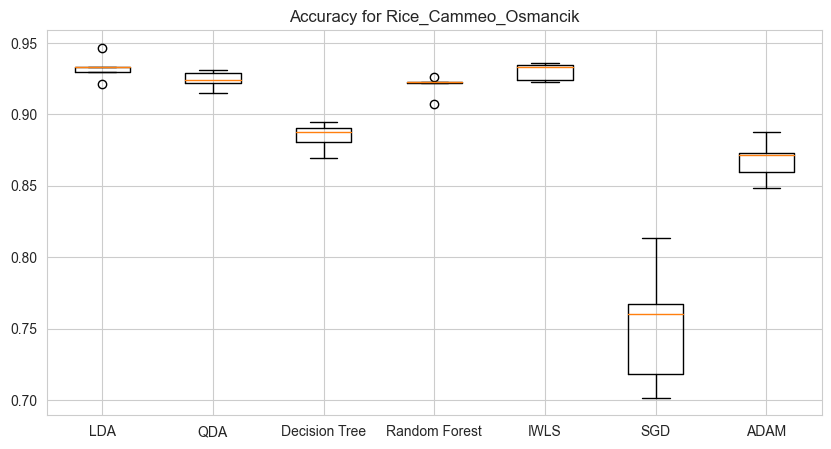

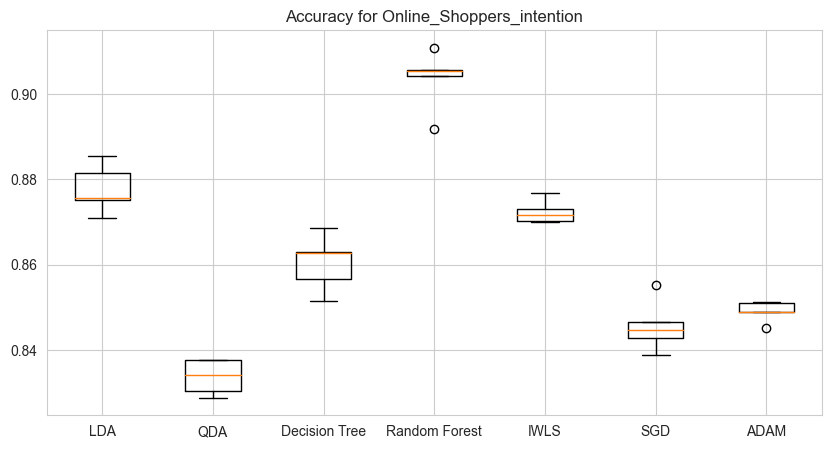

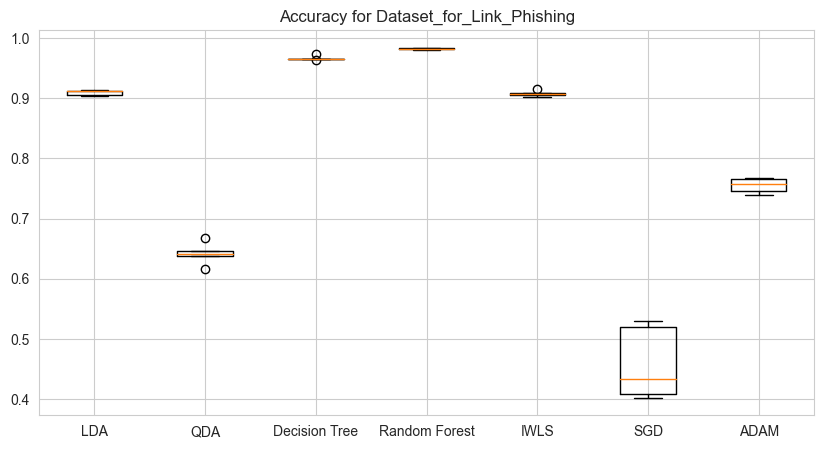

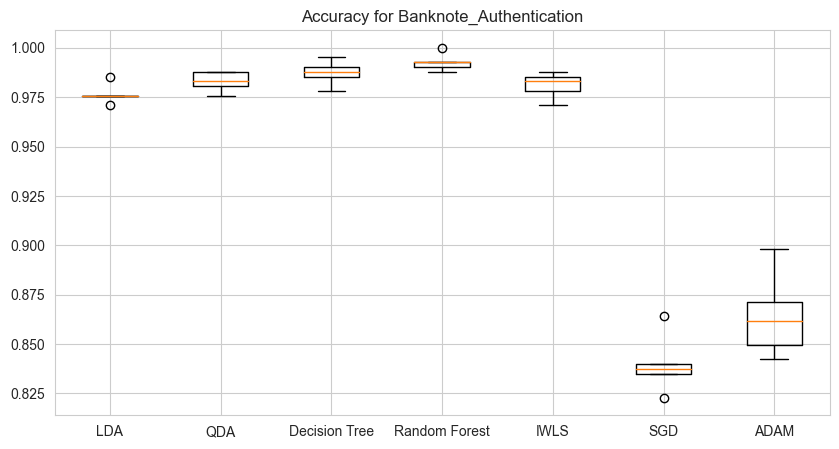

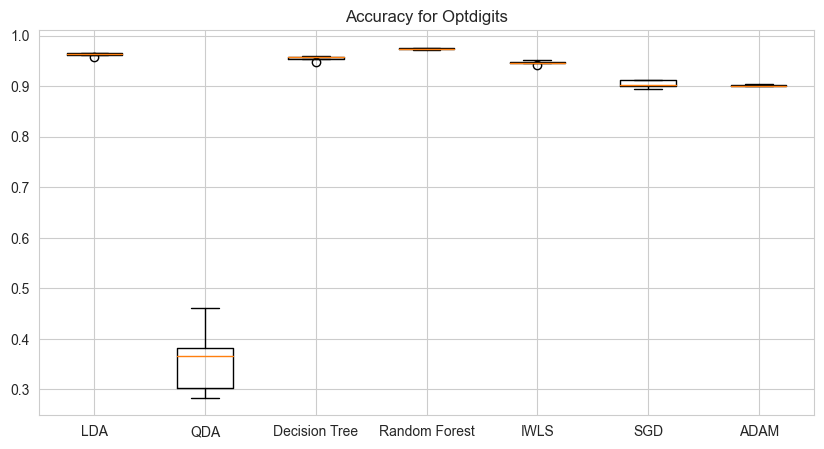

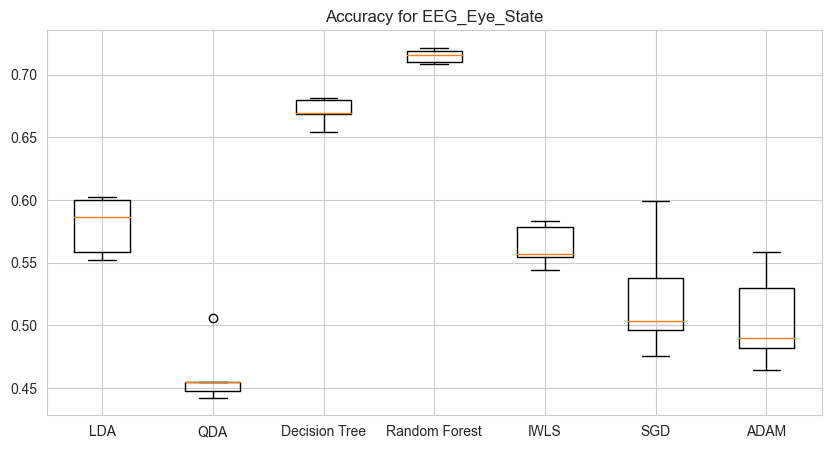

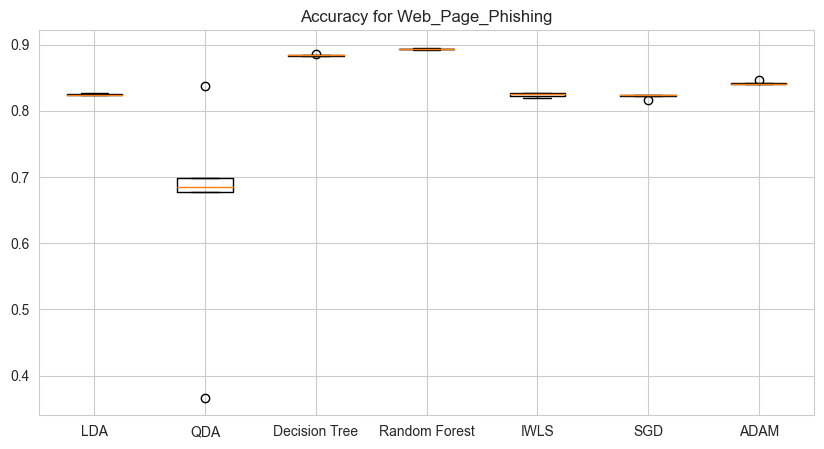

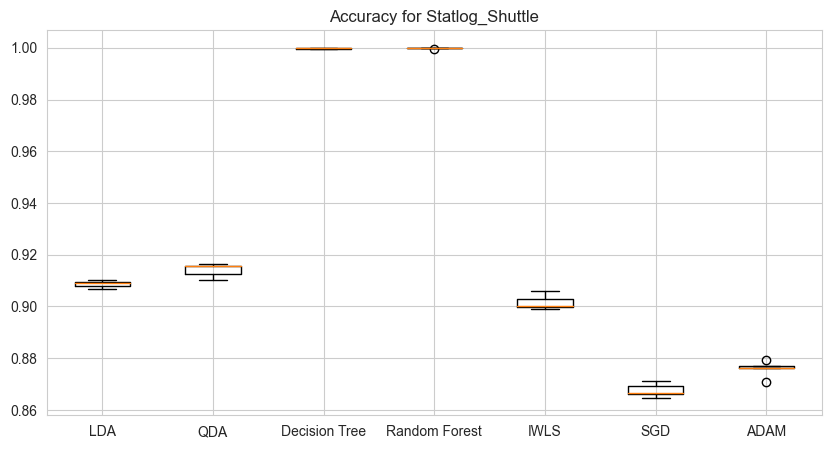

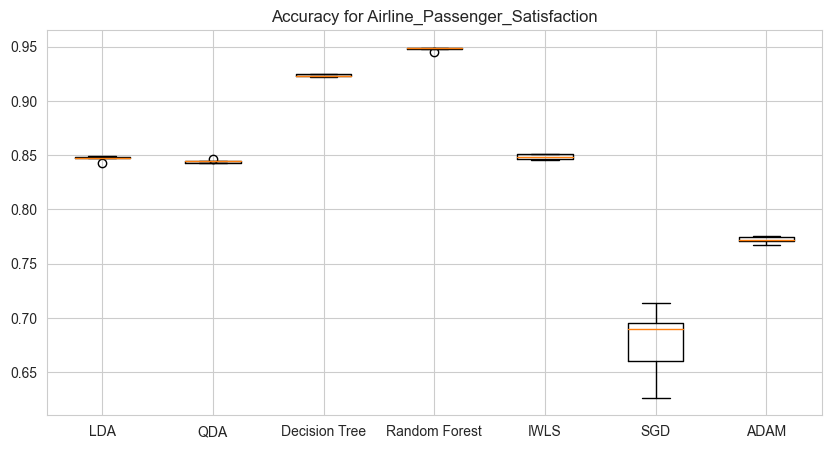

In [13]:
# Plot boxplots only for accuracy

import matplotlib.pyplot as plt

for dataset_name, results_by_method in results_by_dataset_and_method.items():
    accuracies = []
    method_names = []
    for method_name, results in results_by_method.items():
        accuracies.append(results["accuracy"])
        method_names.append(method_name)
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(accuracies)
    plt.xticks(range(1, len(method_names) + 1), method_names)
    plt.title(f"Accuracy for {dataset_name}")
    plt.show()

# Task 3.5
In the case of small datasets, please compare the two versions of the logistic regression: model without interactions and model with interactions. This gives a total of 6 variants of logistic regression (IWLS, SGD, ADAM, IWLS+INT, SGD+INT, ADAM+INT).


In [12]:
# Infuse IWLS with interactions
import traceback
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

iterations = 10
test_size = 0.3

methods = [
    ("IWLS", False, lambda: IRLS(iter_limit=10)),
    ("IWLS+INT", True, lambda: IRLS(iter_limit=10)),
    ("SGD", False, lambda: SGD(iter_limit=500)),
    ("SGD+INT", True, lambda: SGD(iter_limit=500)),
    ("ADAM", False, lambda: ADAM(iter_limit=500)),
    ("ADAM+INT", True, lambda: ADAM(iter_limit=500)),
]

small_datasets = {
    'Rice_Cammeo_Osmancik': datasets['Rice_Cammeo_Osmancik'],
    'Statlog_Shuttle': datasets['Statlog_Shuttle'],
    'Banknote_Authentication': datasets['Banknote_Authentication'],
}

results_by_dataset_and_method_35 = {}

# Load saved results
import json

try:
    with open('results_3.5.json', 'r') as f:
        results_by_dataset_and_method_35 = json.load(f)
        print("Loaded results from file")
except FileNotFoundError:
    pass


# First collect results
for dataset_name, dataset in small_datasets.items():
    if dataset_name in results_by_dataset_and_method_35:
        print(f"Skipping {dataset_name}")
        continue
    
    results_by_method = {}
    for method_name, should_use_interactions, method in methods:
        results = {
            "accuracy": [],
            "f1": [],
            "precision": [],
            "recall": []
        }
        
        tqdm._instances.clear()
        
        bar = tqdm(total=iterations)
        bar.set_description(f"Processing {method_name} on {dataset_name}")
        max_attempts = 10
        current_iteration = 0
        while current_iteration < iterations:
            try:
                X, y = dataset
                method_instance = method()
    
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
                
                interactions = [
                    (i, j)
                    for i in range(X_train.shape[1])
                    for j in range(i + 1, X_train.shape[1])
                ]
                
                if not should_use_interactions:
                    method_instance.fit(X_train, y_train)
                else:
                    method_instance.fit(
                        X_train, 
                        y_train, 
                        interactions=interactions
                    )
                
                y_pred = (
                    method_instance.predict(X_test)
                    if not should_use_interactions
                    else method_instance.predict(X_test, interactions=interactions)
                )
                results["accuracy"].append(balanced_accuracy_score(y_test, y_pred))
                results["f1"].append(f1_score(y_test, y_pred))
                results["precision"].append(precision_score(y_test, y_pred))
                results["recall"].append(recall_score(y_test, y_pred))

                bar.update(1)
                current_iteration += 1
            except Exception as e:
                print(f"Error in {method_name} on {dataset_name} iteration {current_iteration}: {e}, attempts left: {max_attempts}")
                traceback.print_exc()
                max_attempts -= 1
                
                if max_attempts == 0:
                    raise
            
        bar.close()
        results_by_method[method_name] = results
    results_by_dataset_and_method_35[dataset_name] = results_by_method
    
    # Save results
    with open('results_3.5.json', 'w') as f:
        json.dump(results_by_dataset_and_method_35, f)


Loaded results from file
Skipping Rice_Cammeo_Osmancik
Skipping Statlog_Shuttle
Skipping Banknote_Authentication


In [ ]:
# Save results
import json

with open('results_3.5.json', 'w') as f:
    json.dump(results_by_dataset_and_method_35, f)

In [10]:
results_by_dataset_and_method_35

{'Rice_Cammeo_Osmancik': {'IWLS+INT': {'accuracy': [0.9186351706036745,
    0.931758530183727,
    0.9335083114610674,
    0.9405074365704287,
    0.9256342957130359,
    0.9203849518810149,
    0.9300087489063867,
    0.9343832020997376,
    0.9378827646544182,
    0.9308836395450568],
   'f1': [0.9011689691817216,
    0.920892494929006,
    0.9238476953907816,
    0.9311740890688259,
    0.9150849150849151,
    0.9055036344755971,
    0.91701244813278,
    0.9216300940438872,
    0.9282103134479271,
    0.9202825428859738],
   'precision': [0.9197396963123644,
    0.9007936507936508,
    0.9165009940357853,
    0.9274193548387096,
    0.9178356713426854,
    0.9026915113871635,
    0.918918918918919,
    0.9111570247933884,
    0.936734693877551,
    0.9193548387096774],
   'recall': [0.8833333333333333,
    0.941908713692946,
    0.9313131313131313,
    0.9349593495934959,
    0.9123505976095617,
    0.9083333333333333,
    0.9151138716356108,
    0.9323467230443975,
    0.919839679

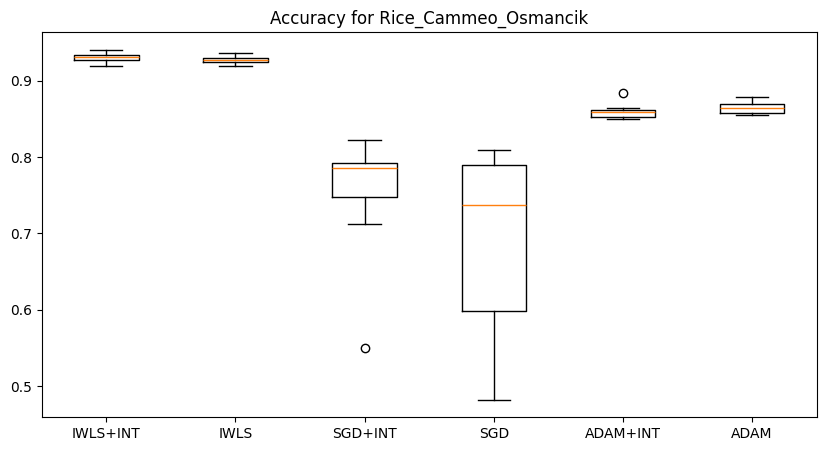

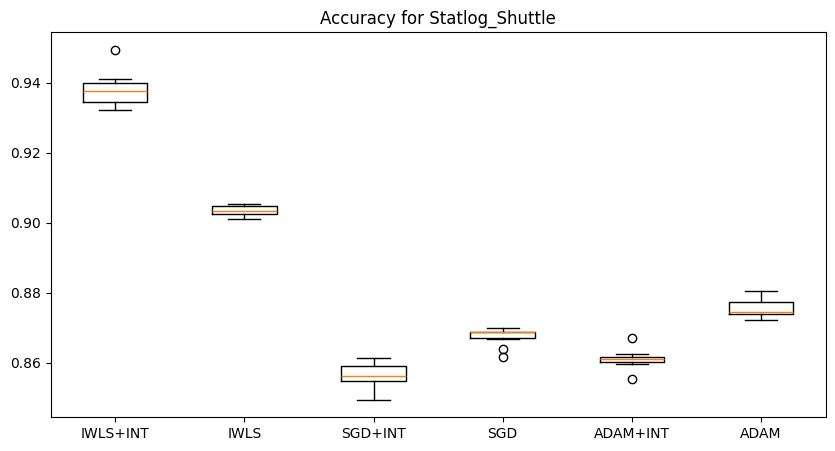

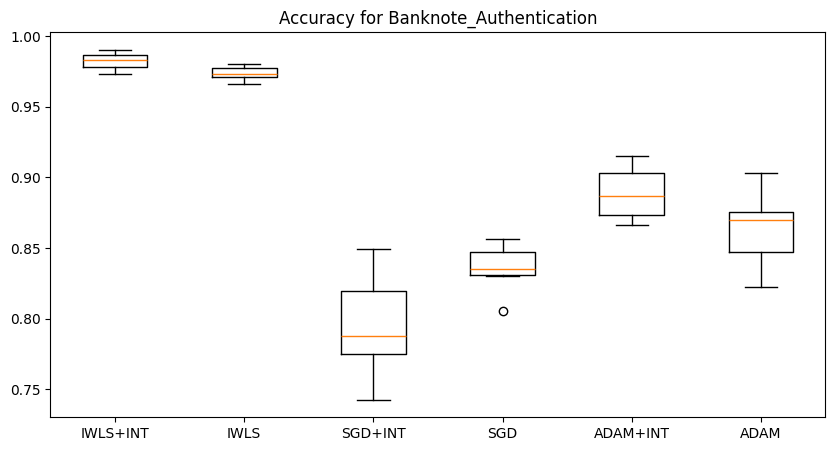

In [11]:
# Plot boxplots only for accuracy

import matplotlib.pyplot as plt

for dataset_name, results_by_method in results_by_dataset_and_method_35.items():
    accuracies = []
    method_names = []
    for method_name, results in results_by_method.items():
        accuracies.append(results["accuracy"])
        method_names.append(method_name)
    
    plt.figure(figsize=(10, 5))
    plt.boxplot(accuracies)
    plt.xticks(range(1, len(method_names) + 1), method_names)
    plt.title(f"Accuracy for {dataset_name}")
    plt.show()